In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
!mkdir -p ~/ .kaggle

In [91]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/


In [92]:
!chmod 600 ~/ .kaggle/kaggle.json


In [93]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [107]:
!unzip /content/fer2013.zip

Archive:  /content/fer2013.zip
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [95]:
import os
import numpy as np
import pandas as pd
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy
import matplotlib.pyplot as plt

In [96]:
{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

seed=24
batch_size=  32

img_data_gen_args = dict(
                      rescale = 1/255.,
                         #rotation_range=90,
                      #width_shift_range=0.3,
                      #height_shift_range=0.3,
                      #shear_range=0.5,
                      #zoom_range=0.3,
                      #horizontal_flip=True,
                      #vertical_flip=True,
                      #fill_mode='reflect'
                         )

# Define the original class to new class mapping (positive, negative, and neutral)
class_mapping = {
    0: 1,  # Angry -> Negative
    1: 1,  # Disgust -> Negative
    2: 1,  # Fear -> Negative
    3: 0,  # Happy -> Positive
    4: 2,  # neutral -> neutral
    5: 1,  # sad -> negative
    6: 0   # surprise -> positive
}



In [97]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
from tensorflow.keras.preprocessing import image_dataset_from_directory


class CustomDirectoryIterator(DirectoryIterator):
    def __getitem__(self, index):
        batch_x, batch_y = super().__getitem__(index)
        new_batch_y = np.zeros((batch_y.shape[0], 3))  # 3 classes: Positive, Negative, Neutral
        for i, y in enumerate(batch_y):
            original_class = np.argmax(y)
            new_class = class_mapping[original_class]
            new_batch_y[i, new_class] = 1
        return batch_x, new_batch_y

In [98]:
# Create an ImageDataGenerator
image_data_generator = ImageDataGenerator(**img_data_gen_args)

# Create a CustomDirectoryIterator for the training images
train_image_generator = CustomDirectoryIterator(
    directory="/content/train",
    image_data_generator=image_data_generator,
    target_size=(224, 224),  # Adjust to the target size (224, 224) is common for transfer learning models like VGG, ResNet, etc.
    batch_size=batch_size,
    interpolation="lanczos",
    color_mode="rgb",  # "rgb" for color images, "grayscale" for black and white images
    class_mode="categorical"  # "categorical" for multi-class classification
)

Found 28709 images belonging to 7 classes.


In [99]:
# Create a CustomDirectoryIterator for the test images
test_image_generator = CustomDirectoryIterator(
    directory="/content/test",
    image_data_generator=image_data_generator,
    target_size=(224, 224),  # Adjust to the target size (224, 224) is common for transfer learning models like VGG, ResNet, etc.
    batch_size=batch_size,
    interpolation="lanczos",
    color_mode="rgb",  # "rgb" for color images, "grayscale" for black and white images
    class_mode="categorical"  # "categorical" for multi-class classification
)

Found 7178 images belonging to 7 classes.


# Sanity check

In [100]:
class_names = ["Positive", "Negative", "Neutral"]

def plot_images_with_labels(images, labels, class_names):
    num_images=9
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        label_index = labels[i].argmax()
        plt.title(class_names[label_index])
        plt.axis('off')
    plt.show()

In [101]:
x_train,y_train = train_image_generator.__getitem__(3)
y_train.shape

(32, 3)

In [102]:
x_test,y_test = test_image_generator.__getitem__(3)
y_test.shape

(32, 3)

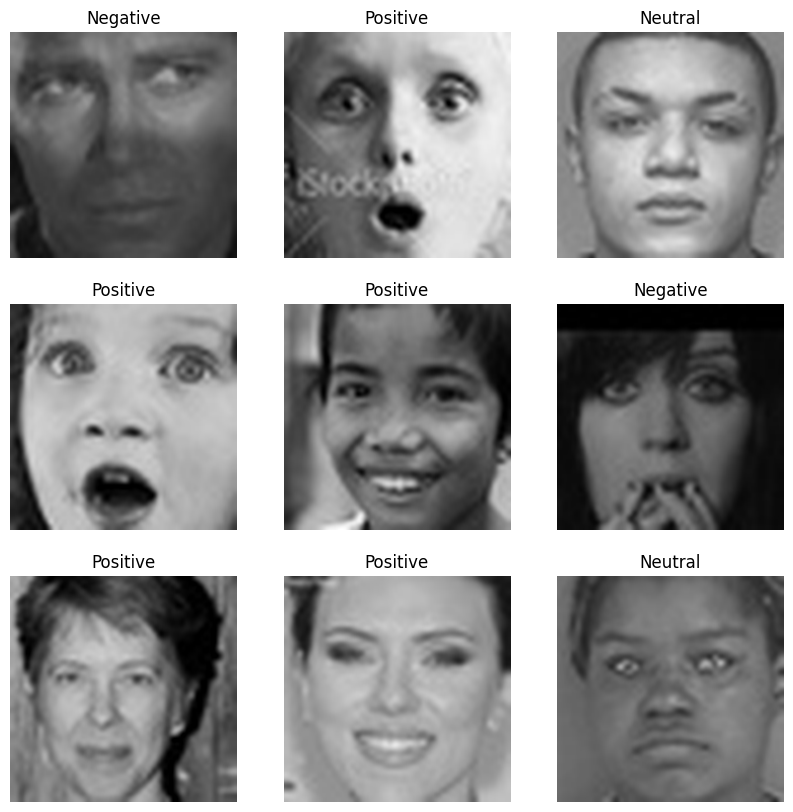

In [103]:
# Plot a 3x3 grid of images with labels
plot_images_with_labels(x_train, y_train, class_names)

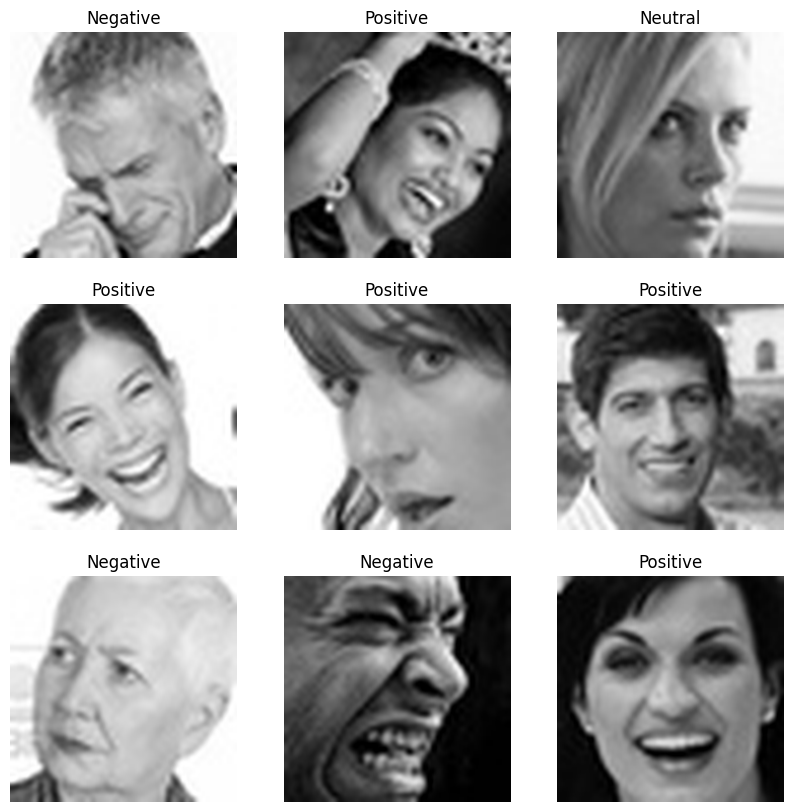

In [104]:
plot_images_with_labels(x_test, y_test, class_names)

# Transfer Learning for classification

In [105]:
import tensorflow as tf
from tensorflow.keras import layers

In [114]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model

# https://medium.com/@skillcate/emotion-detection-model-using-cnn-a-complete-guide-831db1421fae
# CNN Architecture
input = Input(shape = (48,48,1))
conv1 = Conv2D(32,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(input)
conv1 = Dropout(0.1)(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(pool_size = (2,2)) (conv1)
conv2 = Conv2D(64,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool1)
conv2 = Dropout(0.1)(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(pool_size = (2,2)) (conv2)
conv3 = Conv2D(128,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool2)
conv3 = Dropout(0.1)(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(pool_size = (2,2)) (conv3)
conv4 = Conv2D(256,(3, 3), padding = 'same', strides=(1, 1), kernel_regularizer=l2(0.001))(pool3)
conv4 = Dropout(0.1)(conv4)
conv4 = Activation('relu')(conv4)
pool4 = MaxPooling2D(pool_size = (2,2)) (conv4)
flatten = Flatten()(pool4)
dense_1 = Dense(128,activation='relu')(flatten)
drop_1 = Dropout(0.2)(dense_1)
output = Dense(3,activation="sigmoid")(drop_1)

# Model compile
model = Model(inputs=input,outputs=output)
model.compile(optimizer="adam", loss=["categorical_crossentropy"], metrics=['accuracy'])
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 dropout_11 (Dropout)        (None, 48, 48, 32)        0         
                                                                 
 activation_8 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 24, 24, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 24, 24, 64)        18496     
                                                          

In [115]:
## let's introduce the Modelcheckpoint to save the best model for each epoch to avoid errors
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.keras', verbose=1, save_best_only=True)
## let's implement the EarlyStopping!
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss'), checkpointer ]

In [116]:
history = model.fit(train_image_generator,validation_data=test_image_generator,
                    epochs=100, verbose= 1, callbacks=callbacks)


Epoch 1/100


UnknownError: Graph execution error:

Detected at node model_11/conv2d_9/Conv2D defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-116-1b26bccecda3>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 290, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 262, in convolution_op

CUDNN_STATUS_BAD_PARAM
in external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc(4175): 'op' CUDNN_BACKEND_OPERATION: cudnnFinalize Failed
	 [[{{node model_11/conv2d_9/Conv2D}}]] [Op:__inference_train_function_166292]

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
#acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()